In [2]:
import h5py

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib

import sys
import shutil
import glob
import optparse
import os
import json

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

import re

#sys.path.append('/n/coxfs01/cechavarria/repos/2p-pipeline/')
#from pipeline.python.paradigm import align_acquisition_events as acq
#from pipeline.python.traces.utils import get_frame_info
#from pipeline.python.paradigm import utils as util
##
#from pipeline.python.utils import natural_keys, replace_root, print_elapsed_time

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [3]:
%matplotlib inline

In [ ]:
class struct: pass

opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC105'
opts.session = '20190826'
opts.acquisition = 'FOV1_zoom4p0x'
traceid = 'traces101_s2p'
run = 'scenes_run1'
s2p=True
combined = False
iti_pre = 1.0
iti_post = 1.95




#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)

traceid_dir = os.path.join(acquisition_dir, run, 'traces',traceid)

trace_arrays_dir = os.path.join(traceid_dir,'files')
trace_fig_dir = os.path.join(traceid_dir,'figures','np_subtraced_traces')
if not os.path.exists(trace_fig_dir):
        os.makedirs(trace_fig_dir)

In [125]:
      
# Get SCAN IMAGE info for run:
run_dir = traceid_dir.split('/traces')[0]
run = os.path.split(run_dir)[-1]
with open(os.path.join(run_dir, '%s.json' % run), 'r') as fr:
    scan_info = json.load(fr)
all_frames_tsecs = np.array(scan_info['frame_tstamps_sec'])
nslices_full = len(all_frames_tsecs) / scan_info['nvolumes']
nslices = len(scan_info['slices'])
if scan_info['nchannels']==2:
    all_frames_tsecs = np.array(all_frames_tsecs[0::2])


print("N tsecs:", len(all_frames_tsecs))
framerate = scan_info['frame_rate']
volumerate = scan_info['volume_rate']
nvolumes = scan_info['nvolumes']
nfiles = scan_info['ntiffs']





# Load MW info to get stimulus details:
paradigm_dir = os.path.join(acquisition_dir, run, 'paradigm')
mw_fpath = [os.path.join(paradigm_dir, m) for m in os.listdir(paradigm_dir) if 'trials_' in m and m.endswith('json')][0]
with open(mw_fpath,'r') as m:
    mwinfo = json.load(m)
pre_iti_sec = round(mwinfo[list(mwinfo.keys())[0]]['iti_dur_ms']/1E3) 
nframes_iti_full = int(round(pre_iti_sec * volumerate))


trial_list = sorted(mwinfo.keys(), key=natural_keys)


('N tsecs:', 4598)


In [ ]:
df

In [ ]:
curr_slice = 'Slice01'#hard-coding planar data for now
        fid = 0
        for trial_idx, trial_key in enumerate(trial_list):


            if trial_idx > 0:
                if not(fid == mwinfo[trial_key]['block_idx']):
                    print('fid: %i'% (fid))
                    #update fid and reload
                    fid = mwinfo[trial_key]['block_idx']
                    trace_file = [f for f in os.listdir(trace_arrays_dir) if 'File%03d'%(fid+1) in f and f.endswith('hdf5')][0]
                    trace_fn = os.path.join(trace_arrays_dir,trace_file)

                    rawfile = h5py.File(trace_fn, 'r')


                    raw_df = rawfile[curr_slice]['traces']['raw'][:]
                    sub_df = rawfile[curr_slice]['traces']['np_subtracted'][:]
                    np_df = rawfile[curr_slice]['traces']['neuropil'][:]

                    mean_pix_fid[fid,:] = np.squeeze(np.mean(np.squeeze(np.mean(sub_df,0)),0))
            else:
                #load file
                trace_file = [f for f in os.listdir(trace_arrays_dir) if 'File%03d'%(fid+1) in f and f.endswith('hdf5')][0]
                trace_fn = os.path.join(trace_arrays_dir,trace_file)

                rawfile = h5py.File(trace_fn, 'r')
                if 's2p_cell_rois' in rawfile.attrs.keys():
                        file_grp.attrs['s2p_cell_rois'] = rawfile.attrs['s2p_cell_rois']
                raw_df = rawfile[curr_slice]['traces']['raw'][:]
                sub_df = rawfile[curr_slice]['traces']['np_subtracted'][:]
                np_df = rawfile[curr_slice]['traces']['neuropil'][:]

                #get dimension sizes for arrays
                ntrials = len(mwinfo)
                nrois = raw_df.shape[1]
                print('ROIS: %i'%(nrois))

                #use first trial to figure out frame number
                if run_count == 0:
                    idx_on = mwinfo[trial_key]['frame_stim_on']
                    idx_off = mwinfo[trial_key]['frame_stim_off']
                    ntpts = (idx_off-idx_on)+pre_frames+post_frames
                    print('ntpts: %i', ntpts)

                    mean_pix_fid = np.empty((nfiles,nrois))


                #initialize empty arrays
                trial_fid = np.empty((ntrials,))
                parsed_traces_raw = np.empty((ntrials,ntpts,nrois))
                parsed_traces_raw[:] = np.nan
                parsed_traces_sub = np.empty((ntrials,ntpts,nrois))
                parsed_traces_sub[:] = np.nan
                parsed_traces_np = np.empty((ntrials,ntpts,nrois))
                parsed_traces_np[:] = np.nan


            idx0 = (mwinfo[trial_key]['frame_stim_on']-pre_frames)-(nvolumes*fid)
            idx1 = mwinfo[trial_key]['frame_stim_off']+post_frames-(nvolumes*fid)
            #discard time points post-stim offset if there are extra frames in this trial(stim onset alignment is what is most importnt)
            idx_diff = (idx1-idx0)-ntpts
            if idx_diff>0:
                idx1 = idx1-idx_diff
            trial_frames = idx1-idx0

            #get psth
            trial_df_raw = raw_df[idx0:idx1,:]
            trial_df_sub = sub_df[idx0:idx1,:]
            trial_df_np = np_df[idx0:idx1,:]

            parsed_traces_raw[trial_idx,0:trial_frames,:]=trial_df_raw
            parsed_traces_sub[trial_idx,0:trial_frames,:]=trial_df_sub
            parsed_traces_np[trial_idx,0:trial_frames,:]=trial_df_np
            trial_fid[trial_idx] = fid

        #get parsed trace time stamps
        tstamps_indices = np.arange(parsed_traces_raw.shape[1])                          
        volumeperiod = 1/volumerate
        curr_tstamps = (tstamps_indices*volumeperiod)
        curr_tstamps = curr_tstamps - iti_pre

In [ ]:
trace_files = [f for f in os.listdir(trace_arrays_dir) if 'File' in f and f.endswith('hdf5')]

file_idx = 0
trace_file = trace_files[0]
trace_fn = os.path.join(trace_arrays_dir,trace_file)

rawfile = h5py.File(trace_fn, 'r')
raw_df = rawfile['Slice01']['traces']['np_subtracted'][:]

stim_on_frames = []
trials_per_file = 25
for tridx in range(trials_per_file):
    tridx_all = tridx+(trials_per_file*file_idx)
    trial_key = 'trial%05d' % (tridx_all+1)
    stim_on_frames.append(mwinfo[trial_key]['frame_stim_on'])
stim_on_frames = np.array(stim_on_frames)

In [123]:
all_frames_tsecs.shape

(4598,)

In [124]:
nvolumes

4598

In [120]:
nframes_iti_full

134

In [118]:
mwinfo[trial_key]['block_idx']

0

In [119]:
stim_off_frames

array([  184,   365,   546,   727,   907,  1088,  1269,  1450,  1631,
        1811,  1992,  2173,  2354,  2535,  2716,  2896,  3077,  3258,
        3439,  3619,  3800,  3981,  4162,  4343,  4523,  4782,  4963,
        5143,  5324,  5505,  5686,  5866,  6047,  6228,  6409,  6590,
        6771,  6951,  7132,  7313,  7494,  7675,  7855,  8036,  8217,
        8398,  8578,  8759,  8940,  9121,  9380,  9561,  9742,  9923,
       10103, 10284, 10465, 10646, 10826, 11007, 11188, 11369, 11550,
       11730, 11911, 12092, 12273, 12454, 12634, 12815, 12996, 13177,
       13358, 13539, 13719, 13978, 14159, 14339, 14520, 14701, 14882,
       15063, 15243, 15424, 15605, 15786, 15967, 16147, 16328, 16509,
       16690, 16871, 17051, 17232, 17413, 17594, 17775, 17955, 18136,
       18317, 18575, 18756, 18937, 19118, 19299, 19480, 19660, 19841,
       20022, 20203, 20384, 20564, 20745, 20926, 21107, 21288, 21468,
       21649, 21830, 22011, 22192, 22372, 22553, 22734, 22915, 23174,
       23355, 23536,

In [115]:
stim_on_frames

array([ 139,  320,  501,  682,  863, 1044, 1224, 1405, 1586, 1767, 1948,
       2128, 2309, 2490, 2671, 2851, 3032, 3213, 3393, 3574, 3755, 3936,
       4116, 4297, 4478])

In [71]:
#open stimulus condition file
stimconfig_fn = 'trial_conditions.hdf5'
paradigm_dir = os.path.join(acquisition_dir, run, 'paradigm')
stimconfig_filepath = os.path.join(paradigm_dir, 'files', stimconfig_fn)
run_config_grp = h5py.File(stimconfig_filepath, 'r')

trial_config = np.array(run_config_grp['trial_config']).astype('int')

In [72]:
config_run

array([  4.,  14.,   1.,   6.,   2.,   7.,   9.,  12.,   8.,   3.,  11.,
        13.,  10.,   5.,   0.,  13.,   4.,  11.,  10.,  14.,   3.,  12.,
         0.,   2.,   8.,   5.,   9.,   1.,   6.,   7.,  11.,   3.,   1.,
         6.,   5.,   0.,   8.,  13.,   7.,   2.,   9.,  12.,   4.,  14.,
        10.,   1.,   8.,   0.,  10.,   3.,   6.,  13.,   5.,   4.,  12.,
         7.,   9.,  14.,  11.,   2.,   3.,   8.,   0.,  12.,   5.,  14.,
         9.,   7.,   6.,  11.,  13.,  10.,   2.,   4.,   1.,  11.,   4.,
         0.,   8.,   5.,   6.,   7.,  10.,   3.,   9.,  14.,  12.,   2.,
        13.,   1.,   4.,   1.,   2.,   5.,   6.,  14.,   7.,   0.,   9.,
        13.,  10.,   8.,  11.,   3.,  12.,  14.,  12.,   2.,   7.,   8.,
         4.,   6.,  11.,   0.,  13.,  10.,   9.,   1.,   5.,   3.,   2.,
         4.,   1.,   7.,   8.,  11.,  10.,   6.,  13.,  14.,   3.,   9.,
         5.,  12.,   0.,  14.,   9.,  13.,   4.,   1.,   5.,   3.,  11.,
         2.,   7.,   8.,  10.,   0.,   6.,  12.,   

In [11]:
import matplotlib.patches as patches

In [27]:
%matplotlib inline

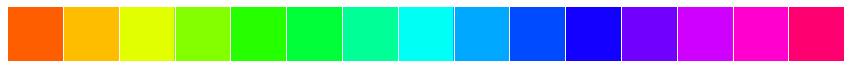

In [104]:
sns.palplot(sns.color_palette('hsv', 15))

In [105]:
color_palette = sns.color_palette('hsv', 15)

In [107]:
color_palette[14]

(1.0, 0.0, 0.44117681801505321)

In [ ]:
all_frames_tsecs

In [132]:
raw_df.shape

(4598, 181)

In [133]:
df = pd.DataFrame(raw_df)

In [136]:
df['time'] = all_frames_tsecs

In [142]:
s2p_cell_rois = np.array([0,1,3])

In [143]:
df[s2p_cell_rois]

,0,1,3
0,5551.510742,1650.557373,542.545776
1,5040.680664,1495.959961,976.609741
2,5027.338867,1717.067505,743.468506
3,5485.016113,1473.992432,907.879883
4,5264.557129,1500.196777,819.268555
5,5438.240234,1452.657104,1037.818726
6,5859.725586,1615.478638,821.388245
7,5409.339844,1663.758789,1102.252319
8,5511.206055,1487.959351,967.099548
9,5443.016602,1426.828491,1317.956543


In [130]:
baseline = np.mean(raw_df[0:nframes_iti_full,:],0)

In [131]:
baseline.shape

(181,)

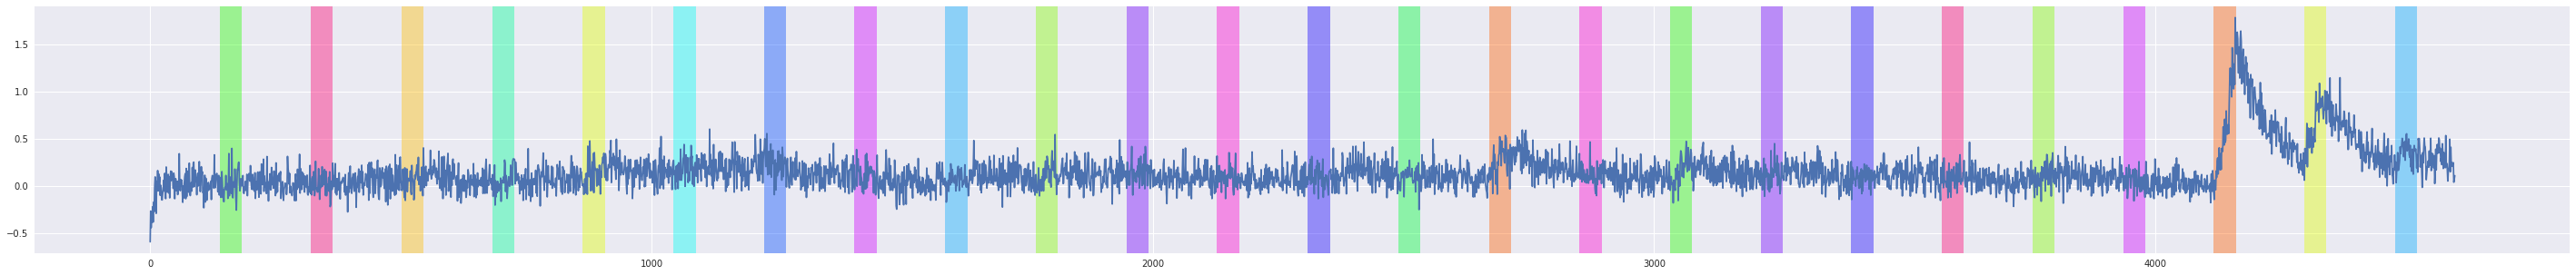

In [121]:
fig=plt.figure(figsize = (30, 5))

ridx = 3
baseline = np.mean(raw_df[0:nframes_iti_full,ridx])
trace = (raw_df[:,ridx] - baseline)/baseline
plt.plot(trace)
axes = plt.gca()
ymin, ymax = axes.get_ylim()
for fidx,f in enumerate(stim_on_frames):
    axes.add_patch(patches.Rectangle((f, ymin), 44, ymax-ymin, linewidth=0, fill=True, color=color_palette[trial_config[fidx]], alpha=0.4));
plt.savefig('tmp.png')

In [74]:
trial_config[fidx]

14

In [9]:
stim_on_frames

array([ 139,  320,  501,  682,  863, 1044, 1224, 1405, 1586, 1767, 1948,
       2128, 2309, 2490, 2671, 2851, 3032, 3213, 3393, 3574, 3755, 3936,
       4116, 4297, 4478])

In [7]:
frame_rate

NameError: name 'frame_rate' is not defined